In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader.data as web
import statsmodels.api as sm
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.formula.api import ols
import seaborn as sns
from scipy import stats
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from pandas_datareader.data import DataReader
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.diagnostic import acorr_ljungbox

## **Code Block 3.1:**
**Data ingestion**


In [2]:
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2024, 12, 31)

# FRED Data
cpi = web.DataReader('CPIAUCSL', 'fred', start, end)
oil = web.DataReader('DCOILWTICO', 'fred', start, end)
oil = oil.resample('MS').first()
ip = web.DataReader('INDPRO', 'fred', start, end)
vix = web.DataReader('VIXCLS', 'fred', start, end)
vix = vix.resample('MS').last()

df = pd.concat([cpi, oil, ip, vix], axis=1)
df.columns = ['CPI', 'Oil', 'IP', 'VIX']
df.head()

,CPI,Oil,IP,VIX
DATE,,,,
2000-01-01,169.3,25.56,91.4092,24.95
2000-02-01,170.0,28.28,91.7245,23.37
2000-03-01,171.0,31.71,92.0830,24.11
2000-04-01,170.9,26.28,92.6659,26.20
2000-05-01,171.2,25.84,92.9347,23.65


## **Code Block 3.2:**
**Stationarity check**


In [3]:
results = []
for col in df.columns:
    dftest = adfuller(df[col], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    results.append({'Variable': col, **dfoutput.to_dict()})  # Unpack dictionary

adf_results_df = pd.DataFrame(results)
adf_results_df = adf_results_df[['Variable', 'Test Statistic', 'p-value', '#Lags Used',
                                 'Number of Observations Used', 'Critical Value (1%)',
                                 'Critical Value (5%)', 'Critical Value (10%)']]
adf_results_df.set_index('Variable', inplace=True)
adf_results_df

,Test Statistic,p-value,#Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
Variable,,,,,,,
CPI,1.191389,9.959258e-01,15.0,284.0,-3.453587,-2.871771,-2.572222
Oil,-2.858239,5.042420e-02,1.0,298.0,-3.452486,-2.871288,-2.571964
IP,-1.925063,3.203639e-01,2.0,297.0,-3.452561,-2.871321,-2.571982
VIX,-5.736446,6.421910e-07,0.0,299.0,-3.452411,-2.871255,-2.571947


## **Code Block 3.3:**
**Data processing for regression analysis**


In [4]:
# % change (∆Pt, ∆Ct, ∆Dt)
df['dCPI'] = df['CPI'].pct_change()
df['dOil'] = df['Oil'].pct_change()
df['dIP'] = df['IP'].pct_change()

# Asymmetric terms
df['dOil_pos'] = df['dOil'].apply(lambda x: x if x > 0 else 0)
df['dOil_neg'] = df['dOil'].apply(lambda x: x if x < 0 else 0)
df['dIP_pos'] = df['dIP'].apply(lambda x: x if x > 0 else 0)
df['dIP_neg'] = df['dIP'].apply(lambda x: x if x < 0 else 0)

# Lagged volatility and geopolitical risk (Gt as a dummy)
df['G'] = np.random.randint(0, 2, size=len(df))  # Placeholder dummy for geopolitical risk
df.dropna(inplace=True)
print(df.tail())

                CPI    Oil        IP    VIX      dCPI      dOil       dIP  \
DATE                                                                        
2024-08-01  314.131  77.74  103.0196  15.00  0.001802 -0.082172  0.004881   
2024-09-01  314.851  71.28  102.5954  16.73  0.002292 -0.083098 -0.004118   
2024-10-01  315.564  70.41  102.2138  23.16  0.002265 -0.012205 -0.003719   
2024-11-01  316.449  69.81  101.9503  13.51  0.002805 -0.008522 -0.002578   
2024-12-01  317.603  68.35  103.0447  17.35  0.003647 -0.020914  0.010735   

            dOil_pos  dOil_neg   dIP_pos   dIP_neg  G  
DATE                                                   
2024-08-01       0.0 -0.082172  0.004881  0.000000  1  
2024-09-01       0.0 -0.083098  0.000000 -0.004118  1  
2024-10-01       0.0 -0.012205  0.000000 -0.003719  0  
2024-11-01       0.0 -0.008522  0.000000 -0.002578  1  
2024-12-01       0.0 -0.020914  0.010735  0.000000  1  


## **Code Block 3.4:**
**Recheck stationarity on transformed datasets**


In [5]:
def adf_test(timeseries):
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used"])
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    return dfoutput

results = []
for column in ['dCPI', 'dOil', 'dIP']:
    result = adf_test(df[column])
    result['Variable'] = column
    results.append(result.to_dict())

adf_results_df = pd.DataFrame(results)
adf_results_df

,Test Statistic,p-value,#Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%),Variable
0,-3.132127,2.426519e-02,14.0,284.0,-3.453587,-2.871771,-2.572222,dCPI
1,-12.887388,4.523727e-24,1.0,297.0,-3.452561,-2.871321,-2.571982,dOil
2,-13.229626,9.643605e-25,1.0,297.0,-3.452561,-2.871321,-2.571982,dIP


## **Table 11:**
**Pearson's correlation**

In [6]:
df[['dOil_pos', 'dOil_neg', 'dIP_pos', 'dIP_neg', 'G', 'VIX']].corr()

,dOil_pos,dOil_neg,dIP_pos,dIP_neg,G,VIX
dOil_pos,1.000000,0.359341,0.441662,0.045330,0.077961,0.035677
dOil_neg,0.359341,1.000000,0.104945,0.502630,0.025223,-0.273986
dIP_pos,0.441662,0.104945,1.000000,0.159395,0.054532,0.044210
dIP_neg,0.045330,0.502630,0.159395,1.000000,-0.046514,-0.285071
G,0.077961,0.025223,0.054532,-0.046514,1.000000,0.040268
VIX,0.035677,-0.273986,0.044210,-0.285071,0.040268,1.000000


## **Code Block 3.5:**
**Regression analysis: OLS**


In [7]:
X = df[['dOil_pos', 'dOil_neg', 'G', 'VIX']]
y = df['dCPI']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   dCPI   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     42.20
Date:                Tue, 21 Oct 2025   Prob (F-statistic):           5.89e-28
Time:                        11:51:25   Log-Likelihood:                 1374.5
No. Observations:                 299   AIC:                            -2739.
Df Residuals:                     294   BIC:                            -2720.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.000      8.283      0.0

## **Code Block 3.7:**
**Data ingestion and processing for VAR & SVAR**


In [8]:
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2024, 12, 31)

cpi = web.DataReader('CPIAUCSL', 'fred', start, end)
oil = web.DataReader('DCOILWTICO', 'fred', start, end)
ip = web.DataReader('INDPRO', 'fred', start, end)
vix = web.DataReader('VIXCLS', 'fred', start, end)

# Resample to monthly frequency
oil = oil.resample('MS').first()
vix = vix.resample('MS').last()

# Merge datasets
df = pd.concat([cpi, oil, ip, vix], axis=1)
df.columns = ['CPI', 'Oil', 'IP', 'VIX']

# Transform to log-differences (growth rates)
df['dCPI'] = np.log(df['CPI']).diff()
df['dOil'] = np.log(df['Oil']).diff()
df['dIP'] = np.log(df['IP']).diff()
df['logVIX'] = np.log(df['VIX'])
df = df[['dCPI', 'dOil', 'dIP', 'logVIX']].dropna()

print(f"Sample period: {df.index[0]} to {df.index[-1]}")
print(f"Observations: {len(df)}")
print(df.head())

Sample period: 2000-02-01 00:00:00 to 2024-12-01 00:00:00
Observations: 299
                dCPI      dOil       dIP    logVIX
DATE                                              
2000-02-01  0.004126  0.101126  0.003443  3.151453
2000-03-01  0.005865  0.114477  0.003901  3.182627
2000-04-01 -0.000585 -0.187824  0.006310  3.265759
2000-05-01  0.001754 -0.016885  0.002897  3.163363
2000-06-01  0.005824  0.155587  0.000722  2.972464


## **Code Block 3.8:**
**Stationarity check: ADF test**


In [9]:
def adf_test(timeseries, var_name):
    """Perform ADF test and return formatted results"""
    result = adfuller(timeseries.dropna(), autolag="AIC")

    output = {
        'Variable': var_name,
        'Test Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2],
        'Observations': result[3],
        'Critical Value (1%)': result[4]['1%'],
        'Critical Value (5%)': result[4]['5%'],
        'Critical Value (10%)': result[4]['10%'],
        'Stationary': 'Yes' if result[1] < 0.05 else 'No'}
    return output

adf_results = []
for column in df.columns:
    result = adf_test(df[column], column)
    adf_results.append(result)

adf_df = pd.DataFrame(adf_results)
print(adf_df.to_string(index=False))

Variable  Test Statistic      p-value  Lags Used  Observations  Critical Value (1%)  Critical Value (5%)  Critical Value (10%) Stationary
    dCPI       -3.136710 2.395307e-02         14           284            -3.453587            -2.871771             -2.572222        Yes
    dOil      -12.697593 1.097506e-23          1           297            -3.452561            -2.871321             -2.571982        Yes
     dIP      -13.238402 9.277362e-25          1           297            -3.452561            -2.871321             -2.571982        Yes
  logVIX       -4.477246 2.161180e-04          1           297            -3.452561            -2.871321             -2.571982        Yes


## **Line plot on stationary data**

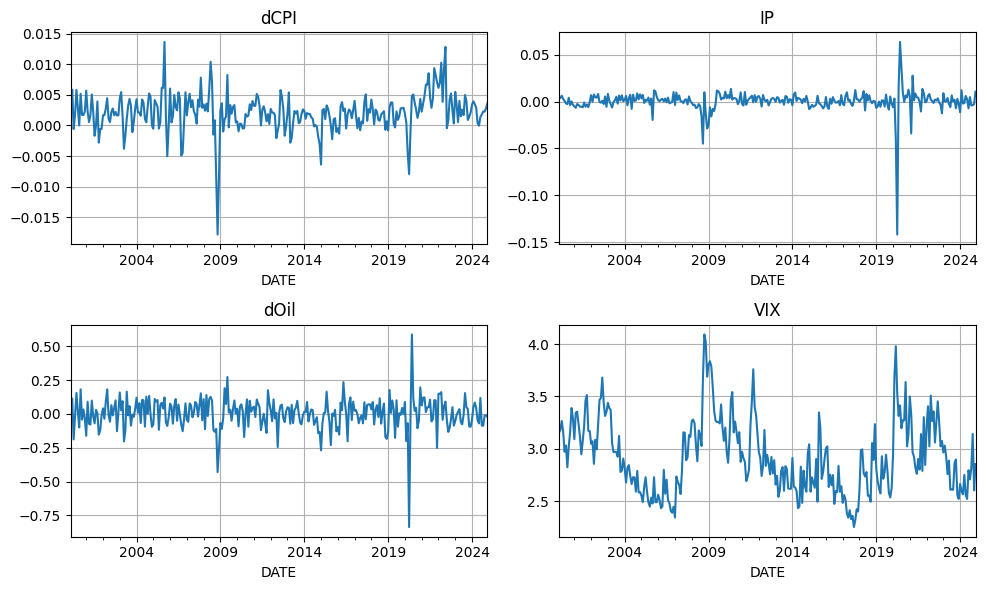

In [10]:
df = df[['dCPI', 'dIP','dOil', 'logVIX']].copy()
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

df['dCPI'].plot(ax=axes[0, 0])
axes[0, 0].set_title('dCPI')
axes[0, 0].grid()

df['dIP'].plot(ax=axes[0, 1])
axes[0, 1].set_title('IP')
axes[0, 1].grid()

df['dOil'].plot(ax=axes[1, 0])
axes[1, 0].set_title('dOil')
axes[1, 0].grid()

df['logVIX'].plot(ax=axes[1, 1])
axes[1, 1].set_title('VIX')
axes[1, 1].grid()

plt.tight_layout()
plt.show()

## **Code Block 3.9:**
**Granger causality test using stationary data**


In [11]:
df_granger = df[['dCPI', 'dOil', 'dIP']].dropna()

pairs = [
    ('dOil', 'dCPI'),   # Does oil help predict inflation?
    ('dIP', 'dCPI'),    # Does production help predict inflation?
    ('dCPI', 'dOil'),   # Does inflation help predict oil prices?
    ('dCPI', 'dIP'),    # Does inflation help predict production?
    ('dOil', 'dIP'),    # Does oil help predict production?
    ('dIP', 'dOil')     # Does production help predict oil prices?
]

granger_results = []

for cause, effect in pairs:
    print(f"\n{'='*60}")
    print(f"Testing: Does {cause} Granger-cause {effect}?")
    print('='*60)

    test_data = df_granger[[effect, cause]]
    result = grangercausalitytests(test_data, maxlag=4)

    p_values = {lag: result[lag][0]['ssr_ftest'][1] for lag in range(1, 5)}

    granger_results.append({
        'Cause': cause,
        'Effect': effect,
        'Lag 1 p-value': p_values[1],
        'Lag 2 p-value': p_values[2],
        'Lag 3 p-value': p_values[3],
        'Lag 4 p-value': p_values[4],
        'Significant': any(p < 0.05 for p in p_values.values())})

granger_df = pd.DataFrame(granger_results)
print("\n" + "="*80)
print("SUMMARY: Granger Causality Test Results")
print("="*80)
print(granger_df.to_string(index=False))


Testing: Does dOil Granger-cause dCPI?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1552  , p=0.6939  , df_denom=295, df_num=1
ssr based chi2 test:   chi2=0.1567  , p=0.6922  , df=1
likelihood ratio test: chi2=0.1567  , p=0.6922  , df=1
parameter F test:         F=0.1552  , p=0.6939  , df_denom=295, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1425  , p=0.8672  , df_denom=292, df_num=2
ssr based chi2 test:   chi2=0.2900  , p=0.8650  , df=2
likelihood ratio test: chi2=0.2898  , p=0.8651  , df=2
parameter F test:         F=0.1425  , p=0.8672  , df_denom=292, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1005  , p=0.9597  , df_denom=289, df_num=3
ssr based chi2 test:   chi2=0.3089  , p=0.9583  , df=3
likelihood ratio test: chi2=0.3087  , p=0.9584  , df=3
parameter F test:         F=0.1005  , p=0.9597  , df_denom=289, df_num=3

Granger Causality
number of lags (no zero) 4
ssr base

## **Code Block 3.10:**
**VAR model estimation**


In [12]:
model = VAR(df)

lag_order_results = model.select_order(maxlags=12)
print("Lag Order Selection Criteria:")
print(lag_order_results.summary())

# Fit VAR using AIC-selected lag order
optimal_lags = lag_order_results.aic
var_result = model.fit(optimal_lags)

print(f"\nVAR Model Summary (Lags = {optimal_lags}):")
print(var_result.summary())

# Check stability
print(f"\nModel Stability: {var_result.is_stable()}")

Lag Order Selection Criteria:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -27.56      -27.51   1.070e-12      -27.54
1       -28.88     -28.63*   2.857e-13      -28.78
2      -29.03*      -28.57  2.459e-13*     -28.85*
3       -29.03      -28.37   2.473e-13      -28.76
4       -29.00      -28.14   2.539e-13      -28.65
5       -28.95      -27.87   2.689e-13      -28.52
6       -28.90      -27.63   2.806e-13      -28.39
7       -28.87      -27.39   2.895e-13      -28.28
8       -28.86      -27.18   2.925e-13      -28.19
9       -28.84      -26.95   3.017e-13      -28.08
10      -28.81      -26.71   3.113e-13      -27.97
11      -28.79      -26.50   3.158e-13      -27.87
12      -28.77      -26.27   3.238e-13      -27.77
--------------------------------------------------

VAR Model Summary (Lags = 2):
  Summary of Regression Results   
Model:                         VAR
Me

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


##**Code Block 3.11:**
**Residual Diagnostic Tests**


In [13]:
# Serial Correlation (Ljung-Box Test)
print("\n" + "="*80)
print("Serial Correlation (Ljung-Box Test)")
print("="*80)

ljung_box_results = []
for col in df.columns:
    lb_test = acorr_ljungbox(var_result.resid[col], lags=[12], return_df=True)
    ljung_box_results.append({
        'Variable': col,
        'Test Statistic': lb_test['lb_stat'].values[0],
        'p-value': lb_test['lb_pvalue'].values[0],
        'Serial Correlation': 'Yes' if lb_test['lb_pvalue'].values[0] < 0.05 else 'No'})
    print(f"\n{col}:")
    print(lb_test)

# Normality (Jarque-Bera Test)
print("\n" + "="*80)
print("Normality (Jarque-Bera Test)")
print("="*80)
normality_test = var_result.test_normality()
print(normality_test.summary())

# Residual Autocorrelation (Portmanteau Test)
print("\n" + "="*80)
print("Portmanteau Test (Multivariate Autocorrelation)")
print("="*80)
portmanteau_test = var_result.test_whiteness(nlags=12)
print(portmanteau_test.summary())


Serial Correlation (Ljung-Box Test)

dCPI:
      lb_stat  lb_pvalue
12  25.240207   0.013725

dIP:
      lb_stat  lb_pvalue
12  10.934409   0.534548

dOil:
     lb_stat  lb_pvalue
12  3.899446   0.985183

logVIX:
     lb_stat  lb_pvalue
12  7.598991   0.815631

Normality (Jarque-Bera Test)
normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
     3.136e+04          15.51   0.000  8
----------------------------------------

Portmanteau Test (Multivariate Autocorrelation)
Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 12 is zero. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value  df
-----------------------------------------
         215.3          190.5   0.002 160
-----------------------------------------


## **Code Block 3.12:**
**Optimal Threshold Selection via Grid Search**

Searching for optimal threshold...
Testing 50 candidate thresholds


OPTIMAL THRESHOLD FOUND
Threshold (θ*): 0.008217
AIC: -49.37
Observations in Low Regime: 269
Observations in High Regime: 30



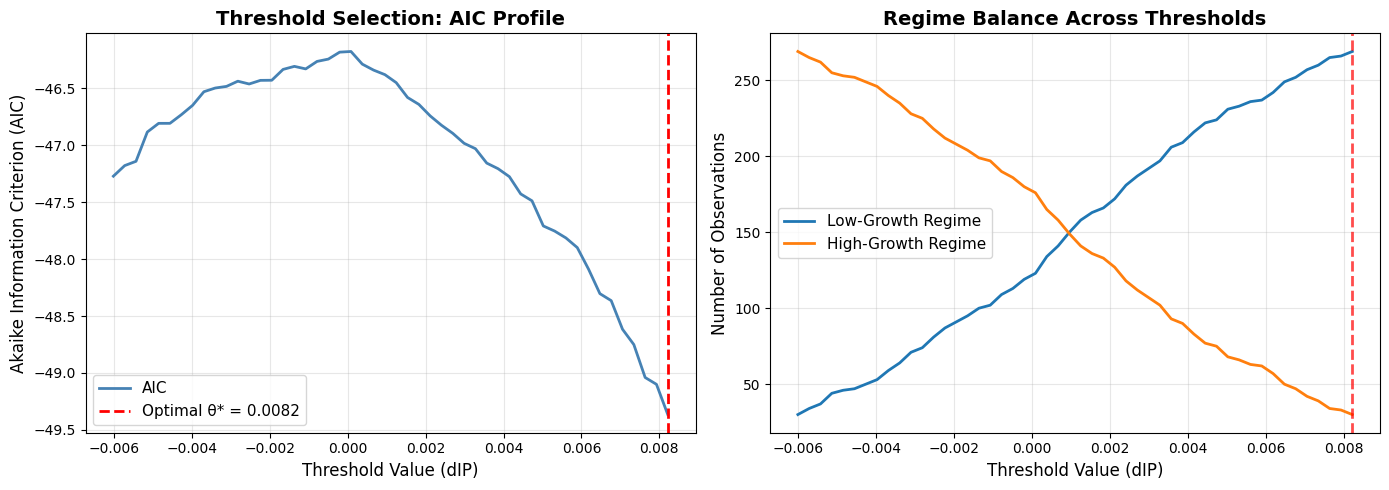

In [14]:
df.index.freq = 'MS'

# Threshold (10th to 90th percentile of dIP)
threshold_candidates = np.linspace(
    df['dIP'].quantile(0.1),
    df['dIP'].quantile(0.9),
    num=50)

threshold_results = []

print("Searching for optimal threshold...")
print(f"Testing {len(threshold_candidates)} candidate thresholds\n")

for thresh in threshold_candidates:
    df['Regime_Indicator'] = (df['dIP'] <= thresh).astype(int)
    df['dOil_low'] = df['dOil'] * df['Regime_Indicator']
    df['dIP_low'] = df['dIP'] * df['Regime_Indicator']
    df['logVIX_low'] = df['logVIX'] * df['Regime_Indicator']

    var_data = df[['dCPI', 'dOil', 'dIP', 'logVIX',
                   'dOil_low', 'dIP_low', 'logVIX_low']].dropna()

    try:
        tvar_model = VAR(var_data)
        tvar_fit = tvar_model.fit(maxlags=6, ic='aic')

        threshold_results.append({
            'threshold': thresh,
            'AIC': tvar_fit.aic,
            'BIC': tvar_fit.bic,
            'Log-Likelihood': tvar_fit.llf,
            'n_low': (df['dIP'] <= thresh).sum(),
            'n_high': (df['dIP'] > thresh).sum()})
    except:
        continue

results_df = pd.DataFrame(threshold_results)

# optimal threshold
optimal_idx = results_df['AIC'].idxmin()
optimal_threshold = results_df.loc[optimal_idx, 'threshold']
optimal_aic = results_df.loc[optimal_idx, 'AIC']

print(f"\n{'='*60}")
print(f"OPTIMAL THRESHOLD FOUND")
print(f"{'='*60}")
print(f"Threshold (θ*): {optimal_threshold:.6f}")
print(f"AIC: {optimal_aic:.2f}")
print(f"Observations in Low Regime: {results_df.loc[optimal_idx, 'n_low']:.0f}")
print(f"Observations in High Regime: {results_df.loc[optimal_idx, 'n_high']:.0f}")
print(f"{'='*60}\n")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# AIC across thresholds
axes[0].plot(results_df['threshold'], results_df['AIC'],
             linewidth=2, color='steelblue', label='AIC')
axes[0].axvline(optimal_threshold, color='red', linestyle='--',
                linewidth=2, label=f'Optimal θ* = {optimal_threshold:.4f}')
axes[0].set_xlabel('Threshold Value (dIP)', fontsize=12)
axes[0].set_ylabel('Akaike Information Criterion (AIC)', fontsize=12)
axes[0].set_title('Threshold Selection: AIC Profile', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# regime balance
axes[1].plot(results_df['threshold'], results_df['n_low'],
             label='Low-Growth Regime', linewidth=2)
axes[1].plot(results_df['threshold'], results_df['n_high'],
             label='High-Growth Regime', linewidth=2)
axes[1].axvline(optimal_threshold, color='red', linestyle='--',
                linewidth=2, alpha=0.7)
axes[1].set_xlabel('Threshold Value (dIP)', fontsize=12)
axes[1].set_ylabel('Number of Observations', fontsize=12)
axes[1].set_title('Regime Balance Across Thresholds', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## **Code Block 3.13:**
**TVAR implementation**

In [15]:
df['Regime'] = np.where(df['dIP'] <= optimal_threshold, 'Low', 'High')

core_vars = ['dCPI', 'dOil', 'dIP', 'logVIX']

low_regime = df[df['Regime'] == 'Low'][core_vars].dropna()
high_regime = df[df['Regime'] == 'High'][core_vars].dropna()

low_model = VAR(low_regime)
low_results = low_model.fit(maxlags=6)

high_model = VAR(high_regime)
high_results = high_model.fit(maxlags=6)

print("Low Growth Regime Results:")
print(low_results.summary())

print("\nHigh Growth Regime Results:")
print(high_results.summary())

Low Growth Regime Results:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 21, Oct, 2025
Time:                     11:51:34
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -27.6956
Nobs:                     263.000    HQIC:                  -28.5080
Log likelihood:           2427.86    FPE:                2.41583e-13
AIC:                     -29.0539    Det(Omega_mle):     1.68004e-13
--------------------------------------------------------------------
Results for equation dCPI
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.001159         0.001888            0.614           0.539
L1.dCPI           0.392802         0.077297            5.082           0.000
L1.dOil          -0.000928         0.002249       

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## **Code Block 3.14:**
**Hypothesis testing: low regime**


In [16]:
all_results = []
for eq_name in low_results.names:
    params = low_results.params[eq_name]
    pvalues = low_results.pvalues[eq_name]

    df_eq = pd.DataFrame({
        'Equation': eq_name,
        'Variable': params.index,
        'Std.Err.': low_results.bse[eq_name],
        't': params / low_results.bse[eq_name],
        'Coef.': params.values,
        'P>|t|': pvalues.values})
    all_results.append(df_eq)

df1 = pd.concat(all_results, ignore_index=True)
df1.head()

,Equation,Variable,Std.Err.,t,Coef.,P>|t|
0,dCPI,const,0.001888,0.613679,0.001159,5.394274e-01
1,dCPI,L1.dCPI,0.077297,5.081727,0.392802,3.740183e-07
2,dCPI,L1.dOil,0.002249,-0.412538,-0.000928,6.799453e-01
3,dCPI,L1.dIP,0.018954,0.988080,0.018728,3.231134e-01
4,dCPI,L1.logVIX,0.000887,-4.010354,-0.003556,6.062786e-05


In [17]:
# H1: Oil shocks on Industrial Production (dIP equation)
h1_df1 = df1[(df1['Equation'] == 'dIP') &
                   (df1['Variable'].str.contains('dOil'))]

# H2: VIX shocks on Industrial Production and Oil Price
h2_ip_df1 = df1[(df1['Equation'] == 'dIP') &
                      (df1['Variable'].str.contains('logVIX'))]

h2_oil_df1 = df1[(df1['Equation'] == 'dOil') &
                       (df1['Variable'].str.contains('logVIX'))]

# H3: Oil shocks on CPI (dCPI equation)
h3_df1 = df1[(df1['Equation'] == 'dCPI') &
                   (df1['Variable'].str.contains('dOil'))]

print("H1: Oil shocks effect on Industrial Production (dIP equation)")
print(h1_df1[['Variable', 'Coef.', 'Std.Err.', 't', 'P>|t|']])
print()

print("H2: VIX shocks effect on Industrial Production (dIP equation)")
print(h2_ip_df1[['Variable', 'Coef.', 'Std.Err.', 't', 'P>|t|']])
print()

print("H2: VIX shocks effect on Oil Prices (dOil equation)")
print(h2_oil_df1[['Variable', 'Coef.', 'Std.Err.', 't', 'P>|t|']])
print()

print("H3: Oil shocks effect on CPI (dCPI equation)")
print(h3_df1[['Variable', 'Coef.', 'Std.Err.', 't', 'P>|t|']])

H1: Oil shocks effect on Industrial Production (dIP equation)
   Variable     Coef.  Std.Err.         t     P>|t|
52  L1.dOil -0.007554  0.008136 -0.928443  0.353178
56  L2.dOil  0.007555  0.008101  0.932596  0.351029
60  L3.dOil -0.009499  0.007987 -1.189332  0.234309
64  L4.dOil  0.001783  0.007890  0.226015  0.821190
68  L5.dOil -0.000071  0.007892 -0.008956  0.992855
72  L6.dOil -0.000102  0.007934 -0.012815  0.989776

H2: VIX shocks effect on Industrial Production (dIP equation)
     Variable     Coef.  Std.Err.         t     P>|t|
54  L1.logVIX -0.011250  0.003208 -3.506347  0.000454
58  L2.logVIX -0.004888  0.004075 -1.199353  0.230391
62  L3.logVIX  0.004222  0.004104  1.028698  0.303622
66  L4.logVIX  0.007552  0.004015  1.881056  0.059964
70  L5.logVIX  0.001410  0.003901  0.361389  0.717809
74  L6.logVIX  0.000025  0.003347  0.007444  0.994061

H2: VIX shocks effect on Oil Prices (dOil equation)
     Variable     Coef.  Std.Err.         t     P>|t|
29  L1.logVIX -0.153495  0

## **Code Block 3:15:**
**Impulse Response Functions (IRFs) plots: Low regime**


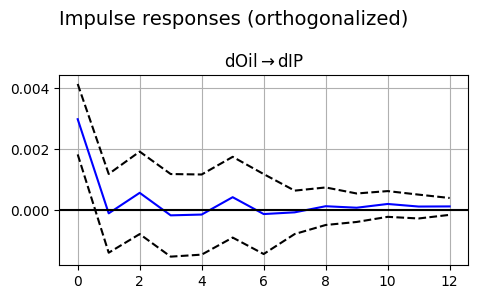

In [18]:
irf = low_results.irf(12)
irf.plot(orth=True,
                impulse='dOil', response='dIP', signif=0.05,
                plot_params=None, figsize=(5, 3),
         subplot_params=None, plot_stderr=True,
         stderr_type='asym',
         repl=1000, seed=None,
         component=None)
plt.grid()
plt.tight_layout()
plt.show()

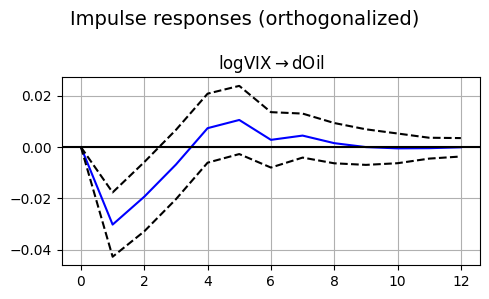

In [19]:
irf.plot(orth=True,
                impulse='logVIX', response='dOil', signif=0.05,
                plot_params=None, figsize=(5, 3),
         subplot_params=None, plot_stderr=True,
         stderr_type='asym',
         repl=1000, seed=None,
         component=None)
plt.grid()
plt.tight_layout()
plt.show()

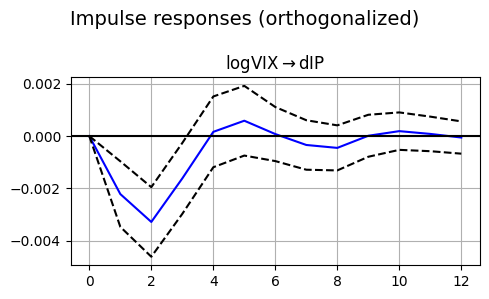

In [20]:
irf.plot(orth=True,
                impulse='logVIX', response='dIP', signif=0.05,
                plot_params=None, figsize=(5, 3),
         subplot_params=None, plot_stderr=True,
         stderr_type='asym',
         repl=1000, seed=None,
         component=None)
plt.grid()
plt.tight_layout()
plt.show()

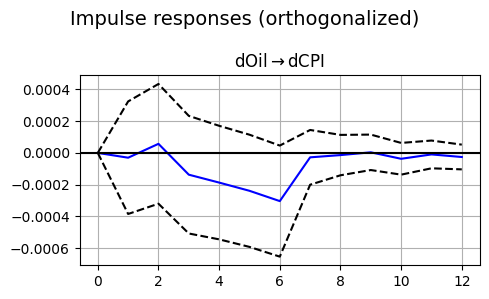

In [21]:
irf.plot(orth=True,
                impulse='dOil', response='dCPI', signif=0.05,
                plot_params=None, figsize=(5, 3),
         subplot_params=None, plot_stderr=True,
         stderr_type='asym',
         repl=1000, seed=None,
         component=None)
plt.grid()
plt.tight_layout()
plt.show()

## **Code Block 3.16:**
**Hypothesis testing: high regime**

In [22]:
all_results = []

for eq_name in high_results.names:
    params = high_results.params[eq_name]
    pvalues = high_results.pvalues[eq_name]

    df_eq = pd.DataFrame({
        'Equation': eq_name,
        'Variable': params.index,
        'Std.Err.': high_results.bse[eq_name],
        't': params / high_results.bse[eq_name],
        'Coef.': params.values,
        'P>|t|': pvalues.values})
    all_results.append(df_eq)

df2 = pd.concat(all_results, ignore_index=True)
df2.head()

,Equation,Variable,Std.Err.,t,Coef.,P>|t|
0,dCPI,const,2.043229e-09,-2.694672e+07,-0.055058,0.0
1,dCPI,L1.dCPI,5.874624e-08,-5.971529e+06,-0.350805,0.0
2,dCPI,L1.dOil,8.733294e-10,4.648443e+06,0.004060,0.0
3,dCPI,L1.dIP,5.415314e-09,2.988291e+06,0.016183,0.0
4,dCPI,L1.logVIX,4.650033e-10,2.531171e+07,0.011770,0.0


In [23]:
# H1: Oil shocks on Industrial Production (dIP equation)
h1_df2 = df2[(df2['Equation'] == 'dIP') &
                   (df2['Variable'].str.contains('dOil'))]

# H2: VIX shocks on Industrial Production and Oil Price
h2_ip_df2 = df2[(df2['Equation'] == 'dIP') &
                      (df2['Variable'].str.contains('logVIX'))]

h2_oil_df2 = df2[(df2['Equation'] == 'dOil') &
                       (df2['Variable'].str.contains('logVIX'))]

# H3: Oil shocks on CPI (dCPI equation)
h3_df2 = df2[(df2['Equation'] == 'dCPI') &
                   (df2['Variable'].str.contains('dOil'))]

print("H1: Oil shocks effect on Industrial Production (dIP equation)")
print(h1_df2[['Variable', 'Coef.', 'Std.Err.', 't', 'P>|t|']])
print()

print("H2: VIX shocks effect on Industrial Production (dIP equation)")
print(h2_ip_df2[['Variable', 'Coef.', 'Std.Err.', 't', 'P>|t|']])
print()

print("H2: VIX shocks effect on Oil Prices (dOil equation)")
print(h2_oil_df2[['Variable', 'Coef.', 'Std.Err.', 't', 'P>|t|']])
print()

print("H3: Oil shocks effect on CPI (dCPI equation)")
print(h3_df2[['Variable', 'Coef.', 'Std.Err.', 't', 'P>|t|']])

H1: Oil shocks effect on Industrial Production (dIP equation)
   Variable     Coef.      Std.Err.             t  P>|t|
52  L1.dOil  0.070997  1.626843e-08  4.364086e+06    0.0
56  L2.dOil  0.280280  3.315045e-08  8.454797e+06    0.0
60  L3.dOil  0.374041  1.824642e-08  2.049942e+07    0.0
64  L4.dOil  0.407732  1.586772e-07  2.569567e+06    0.0
68  L5.dOil  0.443286  1.828611e-07  2.424168e+06    0.0
72  L6.dOil  0.242877  8.226589e-08  2.952345e+06    0.0

H2: VIX shocks effect on Industrial Production (dIP equation)
     Variable     Coef.      Std.Err.             t  P>|t|
54  L1.logVIX  0.061679  8.662110e-09  7.120510e+06    0.0
58  L2.logVIX  0.028992  1.969907e-08  1.471720e+06    0.0
62  L3.logVIX  0.013181  2.025785e-08  6.506483e+05    0.0
66  L4.logVIX  0.065334  1.189902e-08  5.490735e+06    0.0
70  L5.logVIX  0.001793  9.152519e-10  1.959111e+06    0.0
74  L6.logVIX -0.007466  6.108617e-09 -1.222209e+06    0.0

H2: VIX shocks effect on Oil Prices (dOil equation)
     Varia

##**Code Block 3.17:**
**Impulse Response Functions (IRFs) plots: High regime**

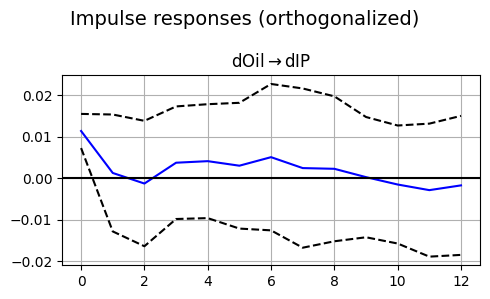

In [24]:
high_results1 = high_model.fit(maxlags=5)
irf2 = high_results1.irf(12)
irf2.plot(orth=True,
                impulse='dOil', response='dIP', signif=0.05,
                plot_params=None, figsize=(5, 3),
         subplot_params=None, plot_stderr=True,
         stderr_type='asym',
         repl=1000, seed=None,
         component=None)
plt.grid()
plt.tight_layout()
plt.show()

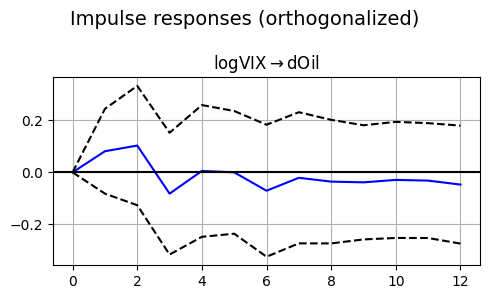

In [25]:
irf2.plot(orth=True,
                impulse='logVIX', response='dOil', signif=0.05,
                plot_params=None, figsize=(5, 3),
         subplot_params=None, plot_stderr=True,
         stderr_type='asym',
         repl=1000, seed=None,
         component=None)
plt.grid()
plt.tight_layout()
plt.show()

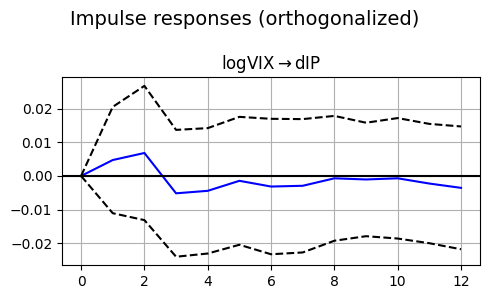

In [26]:
irf2.plot(orth=True,
                impulse='logVIX', response='dIP', signif=0.05,
                plot_params=None, figsize=(5, 3),
         subplot_params=None, plot_stderr=True,
         stderr_type='asym',
         repl=1000, seed=None,
         component=None)
plt.grid()
plt.tight_layout()
plt.show()

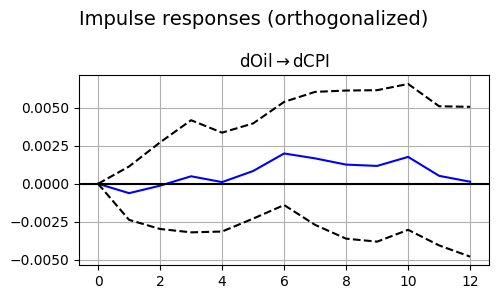

In [27]:
irf2.plot(orth=True,
                impulse='dOil', response='dCPI', signif=0.05,
                plot_params=None, figsize=(5, 3),
         subplot_params=None, plot_stderr=True,
         stderr_type='asym',
         repl=1000, seed=None,
         component=None)
plt.grid()
plt.tight_layout()
plt.show()

## **Code Block 3.18:**
**Markov Regime Switching model**

In [28]:
df.columns

Index(['dCPI', 'dIP', 'dOil', 'logVIX', 'Regime_Indicator', 'dOil_low',
       'dIP_low', 'logVIX_low', 'Regime'],
      dtype='object')

In [29]:
mrs_data = df[['dCPI', 'dIP', 'dOil', 'logVIX']]

model = MarkovRegression(
    endog = mrs_data['dCPI'],
    exog = mrs_data[['dOil', 'dIP', 'logVIX']],
    k_regimes = 2,
    trend = 'n',
    switching_variance = True)

results = model.fit()
print(results.summary())

                        Markov Switching Model Results                        
Dep. Variable:                   dCPI   No. Observations:                  299
Model:               MarkovRegression   Log Likelihood                1425.648
Date:                Tue, 21 Oct 2025   AIC                          -2831.295
Time:                        11:51:40   BIC                          -2794.291
Sample:                    02-01-2000   HQIC                         -2816.485
                         - 12-01-2024                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dOil           0.0106      0.001      8.480      0.000       0.008       0.013
dIP            0.0106      0.011      0.978      0.3

In [30]:
print(results.regime_transition)

[[[0.97920466]
  [0.1068856 ]]

 [[0.02079534]
  [0.8931144 ]]]


## **Code Block 3.19:**
**Smoothed probability plot**

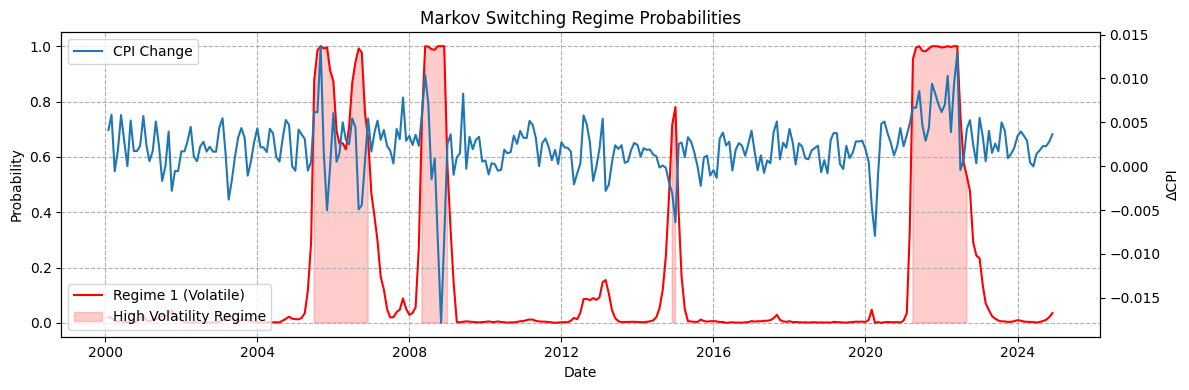

In [31]:
smoothed_probs = results.smoothed_marginal_probabilities

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df.index, smoothed_probs[1], label='Regime 1 (Volatile)', color='red', linewidth=1.5)
ax.fill_between(df.index, smoothed_probs[1], where=(smoothed_probs[1] > 0.5),
                color='red', alpha=0.2, label='High Volatility Regime')

ax.set_title('Markov Switching Regime Probabilities')
ax.set_ylabel('Probability')
ax.set_xlabel('Date')
ax.legend(loc='lower left')
ax.grid(True, linestyle='--')

ax2 = ax.twinx()
ax2.plot(df.index, df['dCPI'], label='CPI Change')
ax2.set_ylabel('ΔCPI')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

## **Code Block 3.20:**
**Structural break report**

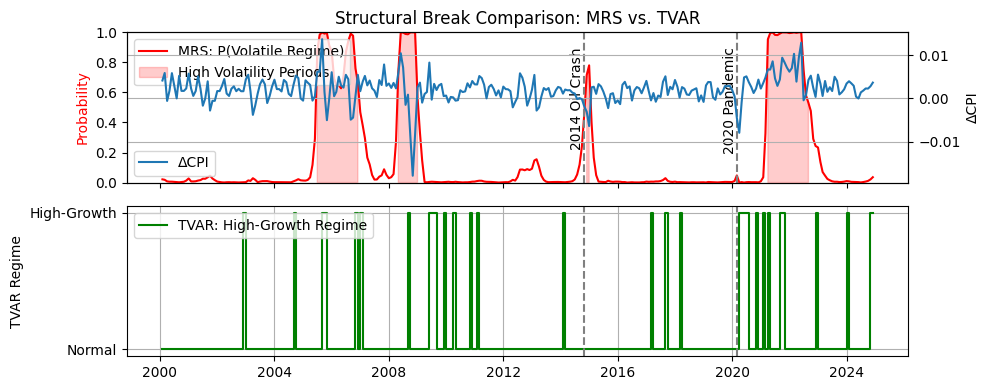

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4), sharex=True)

mrs_probs = results.smoothed_marginal_probabilities[1]

ax1.plot(df.index, mrs_probs, color='red', label='MRS: P(Volatile Regime)')
ax1.fill_between(df.index, mrs_probs, where=(mrs_probs>0.5),
                color='red', alpha=0.2, label='High Volatility Periods')
ax1.set_ylabel('Probability', color='red')
ax1.set_ylim(0, 1)
ax1.legend(loc='upper left')

ax1b = ax1.twinx()
ax1b.plot(df.index, df['dCPI'], label='ΔCPI')
ax1b.set_ylabel('ΔCPI')
ax1b.legend(loc='lower left')
ax1b.grid()

df['Threshold_Regime'] = (df['dIP'] > optimal_threshold).astype(int)
ax2.plot(df.index, df['Threshold_Regime'],
         color='green', drawstyle='steps', label='TVAR: High-Growth Regime')
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['Normal', 'High-Growth'])
ax2.set_ylabel('TVAR Regime')
ax2.legend(loc='upper left')
ax2.grid()

events = {
    '2008 Crisis': pd.to_datetime('2008-09-15'),
    '2014 Oil Crash': pd.to_datetime('2014-11-01'),
    '2020 Pandemic': pd.to_datetime('2020-03-01')}
for event, date in events.items():
    if date in df.index:
        ax1.axvline(date, color='gray', linestyle='--')
        ax2.axvline(date, color='gray', linestyle='--')
        ax1.text(date, 0.9, event, rotation=90, va='top', ha='right')
        ax1.grid()

plt.title('Structural Break Comparison: MRS vs. TVAR')
plt.tight_layout()
plt.show()

## **Code Block 3.21:**
**Hypotheses testing**

In [33]:
pos_oil_shocks = mrs_data[mrs_data['dOil'] > 0]['dIP']
neg_oil_shocks = mrs_data[mrs_data['dOil'] < 0]['dIP']

# Test mean difference (t-test)
t_stat_h1, p_value_h1 = stats.ttest_ind(pos_oil_shocks, neg_oil_shocks, equal_var=False)
print(f"H1 - Impact of Oil Shocks on Industrial Production (t-stat={t_stat_h1:.3f}, p-value={p_value_h1:.3f})")

pos_vix_shocks = mrs_data[mrs_data['logVIX'] > mrs_data['logVIX'].median()]
neg_vix_shocks = mrs_data[mrs_data['logVIX'] <= mrs_data['logVIX'].median()]

# Industrial Production
t_stat_ip, p_value_ip = stats.ttest_ind(
    pos_vix_shocks['dIP'], neg_vix_shocks['dIP'], equal_var=False)
# Oil Prices
t_stat_oil, p_value_oil = stats.ttest_ind(
    pos_vix_shocks['dOil'], neg_vix_shocks['dOil'], equal_var=False)

print(f"H2 - VIX Impact on Industrial Production (t-stat={t_stat_ip:.3f}, p-value={p_value_ip:.3f})")
print(f"H2 - VIX Impact on Oil Prices (t-stat={t_stat_oil:.3f}, p-value={p_value_oil:.3f})")

cpi_pos_oil = mrs_data[mrs_data['dOil'] > 0]['dCPI']
cpi_neg_oil = mrs_data[mrs_data['dOil'] < 0]['dCPI']
t_stat_h3, p_value_h3 = stats.ttest_ind(cpi_pos_oil, cpi_neg_oil, equal_var=False)
print(f"H3 - CPI Response to Oil Shocks (t-stat={t_stat_h3:.3f}, p-value={p_value_h3:.3f})")

H1 - Impact of Oil Shocks on Industrial Production (t-stat=2.123, p-value=0.035)
H2 - VIX Impact on Industrial Production (t-stat=-1.584, p-value=0.115)
H2 - VIX Impact on Oil Prices (t-stat=-1.145, p-value=0.253)
H3 - CPI Response to Oil Shocks (t-stat=7.975, p-value=0.000)


## **Code Block 3.22:**
**Counterfactual inflation trajectories by regime**

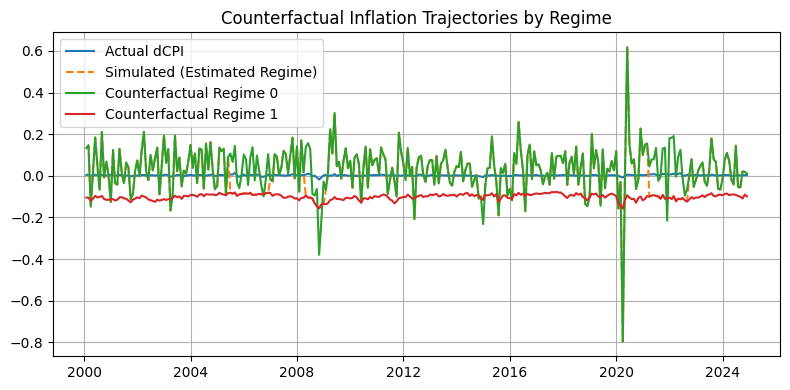

In [34]:
smoothed_probs = results.smoothed_marginal_probabilities[1]
predicted_regimes = results.smoothed_marginal_probabilities.idxmax(axis=1)

params = results.params
n_obs = len(mrs_data)
n_exog = 3

# coefficients per regime
coef_regime_0 = params.iloc[0:n_exog].values
coef_regime_1 = params.iloc[n_exog:2*n_exog].values

intercept_0 = 0
intercept_1 = 0

exog = mrs_data[['dOil', 'dIP', 'logVIX']].values
index = mrs_data.index

y_sim_actual = []
y_sim_r0 = []
y_sim_r1 = []

for t in range(n_obs):
    x_t = exog[t]

    # Simulated values using regime-specific coefficients
    y0 = intercept_0 + np.dot(coef_regime_0, x_t)
    y1 = intercept_1 + np.dot(coef_regime_1, x_t)

    # Actual regime (based on max posterior prob)
    if predicted_regimes.iloc[t] == 0:
        y_actual = y0
    else:
        y_actual = y1

    y_sim_r0.append(y0)
    y_sim_r1.append(y1)
    y_sim_actual.append(y_actual)

counterfactual_df = pd.DataFrame({
    'Actual dCPI': mrs_data['dCPI'].values,
    'Simulated (Estimated Regime)': y_sim_actual,
    'Counterfactual (Regime 0 only)': y_sim_r0,
    'Counterfactual (Regime 1 only)': y_sim_r1}, index=index)

plt.figure(figsize=(8, 4))
plt.plot(counterfactual_df['Actual dCPI'], label='Actual dCPI')
plt.plot(counterfactual_df['Simulated (Estimated Regime)'], label='Simulated (Estimated Regime)', linestyle='--')
plt.plot(counterfactual_df['Counterfactual (Regime 0 only)'], label='Counterfactual Regime 0')
plt.plot(counterfactual_df['Counterfactual (Regime 1 only)'], label='Counterfactual Regime 1')
plt.title('Counterfactual Inflation Trajectories by Regime')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
# Extract counterfactual inflation for Regime 0 and Regime 1
regime0 = counterfactual_df['Counterfactual (Regime 0 only)']
regime1 = counterfactual_df['Counterfactual (Regime 1 only)']

# H1a: Test if the MEAN of Regime 0 and Regime 1 inflation differ (t-test)
t_stat_mean, p_value_mean = stats.ttest_ind(regime0, regime1, equal_var=False)  # Welch's t-test

# H1b: Test if the VARIANCE of Regime 0 and Regime 1 inflation differ (F-test)
f_stat_var = np.var(regime0, ddof=1) / np.var(regime1, ddof=1)
dof0 = len(regime0) - 1
dof1 = len(regime1) - 1
p_value_var = 2 * min(stats.f.cdf(f_stat_var, dof0, dof1), 1 - stats.f.cdf(f_stat_var, dof0, dof1))

print(f"H1a - Mean Difference Test (t-stat={t_stat_mean:.3f}, p-value={p_value_mean:.3f})")
print(f"H1b - Variance Difference Test (F-stat={f_stat_var:.3f}, p-value={p_value_var:.3f})")


H1a - Mean Difference Test (t-stat=20.924, p-value=0.000)
H1b - Variance Difference Test (F-stat=67.619, p-value=0.000)
